In [1]:
import numpy as np
import pandas as pd
import glob, os
import itertools
import matplotlib.image as mpimg
import pickle
import math
import json
from functools import *

%matplotlib inline
import matplotlib.pyplot as plt

MAX_FRAME_NUM = 1000000

In [2]:
failure_starts = pd.read_csv('/mnt/ml-data4/tsd/val_mp4s.csv', header=None, index_col=0).sample(frac=1)
failure_starts['start1'] = MAX_FRAME_NUM
failure_starts['start2'] = MAX_FRAME_NUM

selected_failure_starts = pd.read_csv('/mnt/ml-data4/tsd/failure_starts.csv', index_col=0, names=['start1', 'start2'])
selected_failure_starts['start1'] = selected_failure_starts['start1']*25/30 # account for the 25fps vs 30 fps bug in the code.
selected_failure_starts['start2'] = selected_failure_starts['start2']*25/30 # account for the 25fps vs 30 fps bug in the code.
max_id = max(selected_failure_starts.index)
failure_starts = failure_starts[failure_starts.index <= max_id]
failure_starts = failure_starts[failure_starts.index >= 4572]
failure_starts.update(selected_failure_starts)
failure_starts.loc[failure_starts['start2'] < 0, 'start2'] = MAX_FRAME_NUM

vids = [str(i) for i in failure_starts.index.values.tolist()]

failed_videos = failure_starts[failure_starts.start1 < MAX_FRAME_NUM]
succeeded_videos = failure_starts[failure_starts.start1 >= MAX_FRAME_NUM]

In [5]:
# baselione - prod performance. Precision: 0.21.  Recall - 0.45

def load_df_from_json(fn):
    if not os.path.isfile(fn):
        return pd.DataFrame()
    l = [ f['fields'] for f in json.load(open(fn, 'r')) if 'fields' in f]
    df = pd.DataFrame(l)
    return df

# def validate_ewm(fn):
#     df = load_df_from_json(fn)
#     if df.empty:
#         return
#     ser = ((df['ewm_mean'] - df['rolling_ewm'])[20:] > 1e-03)
#     return ser[ser].count() == 0

# for vid in alerted.index.values:
#     print(vid)
#     print(validate_ewm('/mnt/ml-data4/tsd/jsons/{}.json'.format(vid)))

def load_detections(vid):
    return load_df_from_json('/mnt/ml-data4/tsd/jsons/{}.json'.format(vid))

settings = dict(THRESHOLD_LOW=0.11, THRESHOLD_HIGH=0.65, INIT_SAFE_FRAME_NUM=30, ROLLING_MEAN_SHORT_MULTIPLE=5.43)

def is_failing(prediction, detective_sensitivity=1.0):
    if prediction.current_frame_num < settings['INIT_SAFE_FRAME_NUM']:
        return False

    adjusted_ewm_mean = prediction.ewm_mean * detective_sensitivity
    if adjusted_ewm_mean < settings['THRESHOLD_LOW'] + prediction.rolling_mean_long:
        return False

    if adjusted_ewm_mean > settings['THRESHOLD_HIGH'] + prediction.rolling_mean_long:
        return True

    if adjusted_ewm_mean > prediction.rolling_mean_short * settings['ROLLING_MEAN_SHORT_MULTIPLE']:
        return True
    
    return False

def detect_failure_start(vid, plot=False, **args):
    det = load_detections(vid)
    if plot:
        det[['current_p', 'ewm_mean', 'rolling_mean_short', 'rolling_mean_long']].plot()

    print(vid)
    det['is_failing'] = det.apply(is_failing, axis=1)
    failing_frames = det[det['is_failing']].index

    if len(failing_frames) > 0:
        return det[det['is_failing']].index[0]


In [3]:
raw_dets = []
for pkl in ['prod1.pkl', 'prod2.pkl', 'prod3.pkl', 'prod4.pkl', 'prod5.pkl', 'prod6.pkl', 'prod7.pkl', 'prod8.pkl', 'prod9.pkl', 'prod10.pkl']:
    raw_dets = raw_dets + pickle.load( open( "/mnt/ml-data4/error-analysis/tsd-val/neg_32213_22300.out/"+pkl, "rb" ) )

dets_map = dict()
for det in raw_dets:
    vid = str(int(det[0].split('-')[1].split('/')[-1]))
    fid = int(det[0].split('-')[2].split('.')[0])
    dets_map.setdefault(vid, []).append([fid, det[1][0][1], det[1][1][1], det[1][2][1]])


In [4]:

def clip(x, lower):
    if x < lower:
        return 0
    return x

def pseudo_moving_avg(input, win_size):
    mean = 0
    output = []
    for j, i in enumerate(input):
        diff =  (i - mean )/float(win_size if win_size < j else j+1)
        mean = mean + diff
        output += [mean]
    
    return output

def load_detections(vid, thresh, ewm_span, rolling_win):

    df = pd.DataFrame(dets_map[vid], columns=['fid', 'p1', 'p2', 'p3'])
    df['accu_detection'] = df.p1.apply(clip, args=(thresh,)) + df.p2.apply(clip, args=(thresh,)) + df.p3.apply(clip, args=(thresh,))
    df['rolling_ewm'] = df.accu_detection.ewm(span=ewm_span).mean()
#     df['rolling_ewm_5'] = df.accu_detection.ewm(span=5).mean()
#     df['rolling_ewm_20'] = df.accu_detection.ewm(span=20).mean()
#     df['rolling_ewm_50'] = df.accu_detection.ewm(span=50).mean()
    avgs = np.array(pseudo_moving_avg(df.accu_detection, rolling_win))
    df['rolling_mean'] = pd.Series(avgs, index=np.arange(0, len(avgs)))
#     avgs = np.array(pseudo_moving_avg(df.accu_detection, 100))
#     df['rolling_mean_100'] = pd.Series(avgs, index=np.arange(0, len(avgs)))
#     avgs = np.array(pseudo_moving_avg(df.accu_detection, 200))
#     df['rolling_mean_200'] = pd.Series(avgs, index=np.arange(0, len(avgs)))

    return df.set_index('fid')


In [714]:
# Random forest

def balance_dataset(ds):
    return ds
    
def load_as_xy(vid, clip_to_failure=False, thresh = 0.16, ewm_span = 9, rolling_win = 50, rolling_multiple = 5.43):
    vid = str(vid)
    df = load_detections(vid, thresh, ewm_span, rolling_win)
    start1 = int(failure_starts.loc[int(vid)].start1)
    start2 = int(failure_starts.loc[int(vid)].start2)
    if start2 >= MAX_FRAME_NUM:
        start2 = len(df)
    
    # give a bit of leeway for start1 since it is a very conservative point
    start1 = start1 + (start2 - start1)//5
    
    print('start1: ', start1)
    print('start2: ', start2)
    
    df['has_failed'] = 0
    df.loc[start1+5:, 'has_failed'] = 1
    df.loc[start2+5:, 'has_failed'] = 2
    x = df.to_numpy()
    
    y = np.zeros((len(df), 1))
    y[start1:] = 1
    y[start2:] = 2
    
    ds = np.concatenate([y, x[:,3:]], axis=1)
    
    # balance dataset
    y_zeros = ds[ds[:,0] < 1]
    y_nonzeros = ds[ds[:,0] >= 1]
    max_y_zeros = max(len(y_nonzeros), 20)
    
    np.random.shuffle(y_zeros)
    return np.vstack([y_nonzeros, y_zeros[:max_y_zeros,:]])
    
#     failure_point = (start1+start2)//2

#     y[failure_point:] = 1
#     if clip_to_failure:
#         failure_point = min(failure_point, len(df))
#         frames = np.hstack([(np.random.randint(0, failure_point, size=3) if failure_point > 2 else []), np.arange(failure_point, min(failure_point+10, len(df)))]).astype(np.int32)
#         return np.concatenate([y, x], axis=1)[frames,:]
#     else:
#         return np.concatenate([y, x], axis=1)


def detect_failure_start(vid, plot=False):
    vid = str(vid)
    
    df = load_detections(vid, thresh = 0.16, ewm_span = 9, rolling_win = 50)

    has_failed = 0
    has_failed_arr = np.array([])
    failed_frame = None
    
    for index, row in df.iterrows():
        x = row.to_numpy()[3:]
        x = np.append(x, [has_failed])
        has_failed = model.predict(x.reshape(1, -1))[0]
        if has_failed == 2 and failed_frame == None:
            failed_frame = index
        
        has_failed_arr = np.append(has_failed_arr, [has_failed])

    if plot:
        plt.plot(df.rolling_ewm)
        plt.plot(has_failed_arr)
            
    return failed_frame
#     predicted_labels = model.predict(load_as_xy(vid)[:,1:]).nonzero()[0]


#     if len(predicted_labels) > 0:
#         if plot:
#             for i in predicted_labels:
#                 plt.plot([i, i],[0,1], linestyle='-', color='r')

#         return predicted_labels[0]

training_vids = np.hstack((failed_videos.head(100).index.values, succeeded_videos.head(1300).index.values))
val_vids = np.hstack((failed_videos.tail(96).index.values, succeeded_videos.tail(1230).index.values))

training_ds = np.vstack([load_as_xy(vid, False) for vid in training_vids])
np.random.shuffle(training_ds)
# val_ds = np.vstack([load_as_xy(vid, False) for vid in val_vids])

from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(training_ds[:,1:],training_ds[:,0])

# from sklearn.linear_model import LogisticRegression
# model =  LogisticRegression(random_state=0)
# model.fit(training_ds[:,1:],training_ds[:,0])

importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
for f in range(training_ds[:,1:].shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(training_ds[:,1:].shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(training_ds[:,1:].shape[1]), indices)
plt.xlim([-1, training_ds[:,1:].shape[1]])
plt.show()

start1:  286
start2:  353
start1:  104
start2:  112
start1:  234
start2:  1035
start1:  24
start2:  53
start1:  0
start2:  0
start1:  39
start2:  42
start1:  1411
start2:  1771
start1:  29
start2:  80
start1:  1740
start2:  6497
start1:  69
start2:  185
start1:  32
start2:  83
start1:  3668
start2:  3744
start1:  204
start2:  1023
start1:  2038
start2:  2498
start1:  755
start2:  1583
start1:  209
start2:  528
start1:  212
start2:  240
start1:  125
start2:  131
start1:  33
start2:  56
start1:  296
start2:  299
start1:  172
start2:  203
start1:  7
start2:  35
start1:  182
start2:  222
start1:  39
start2:  45
start1:  899
start2:  959
start1:  0
start2:  0
start1:  17
start2:  67
start1:  121
start2:  219
start1:  1623
start2:  1662
start1:  100
start2:  128
start1:  89
start2:  115
start1:  94
start2:  191
start1:  247
start2:  955
start1:  348
start2:  357
start1:  86
start2:  181
start1:  61
start2:  186
start1:  56
start2:  164
start1:  7
start2:  35
start1:  55
start2:  276
start1: 

In [5]:
# rolling avg based prediction. Precision: 0.15 Recall: 0.29 based on production params (except long term rolling avg)

def truncated(x, lower, upper):
    if x < lower:
        return -math.inf
    if x > upper:
        return math.inf
    return x

def detect_failure_start(vid, thresh, v_thresh, min_ewm, ewm_span, rolling_win, rolling_multiple, plot=False):
    df = load_detections(str(vid), thresh, ewm_span, rolling_win)
    df['rolling_mean'] = df['rolling_mean'] * rolling_multiple
    detected_failures = df.index[df.rolling_ewm.apply(truncated, args=(min_ewm, v_thresh)) > df.rolling_mean]
    if plot:
        plt.figure()
        df[['rolling_ewm','rolling_mean']].plot()

    if len(detected_failures) > 0:
        return detected_failures.min()

In [ ]:
# Modified rolling avg based prediction

#rolling multiple only. compared to roll avg to date
# repeat matters
# no v_thresh


{'min_ewm': 0.65, 'rolling_multiple': 3.2, 'rolling_win': 300.0, 'thresh': 0.06, 'v_thresh': 1.5, 'ewm_span': 7.0}
{'min_ewm': 0.65, 'rolling_multiple': 3.2, 'rolling_win': 300.0, 'thresh': 0.06, 'v_thresh': 1.5, 'ewm_span': 7.0}


{'fn': [],
 'fp': ['5802',
  '6324',
  '5623',
  '5987',
  '10859',
  '10564',
  '4864',
  '5248',
  '6034',
  '6347',
  '11150',
  '10805',
  '10588',
  '6125',
  '11108',
  '10398',
  '5231',
  '10239',
  '10499',
  '6024',
  '10957',
  '4989',
  '5942',
  '10527',
  '10746',
  '5449',
  '5546',
  '10152',
  '10936',
  '5794',
  '6349',
  '6245',
  '5876',
  '6348',
  '11182',
  '11319',
  '5811',
  '6377',
  '5230',
  '6031',
  '10451',
  '11141',
  '5447',
  '5737',
  '4679',
  '4809',
  '5016',
  '5021',
  '10760',
  '4991',
  '5706',
  '5815',
  '5644',
  '10224'],
 'p': ['6125', '5811'],
 'tn': [],
 'tp': []}

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

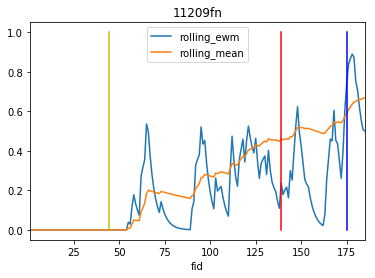

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

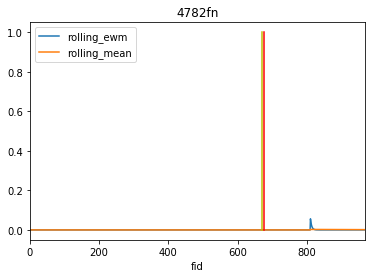

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

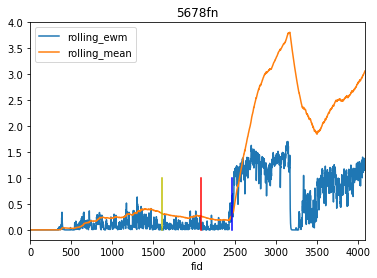

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

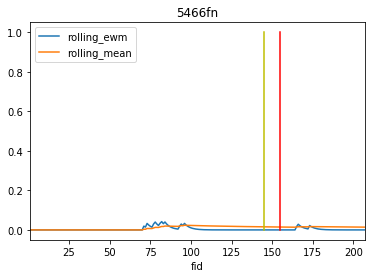

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

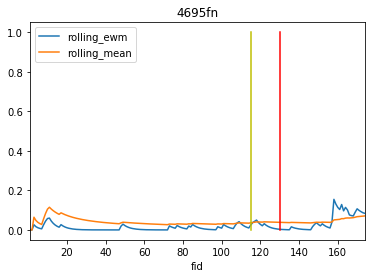

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

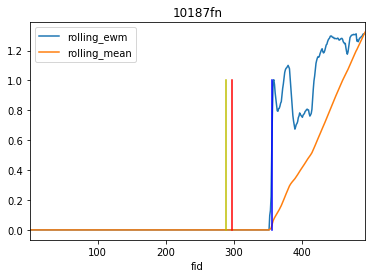

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

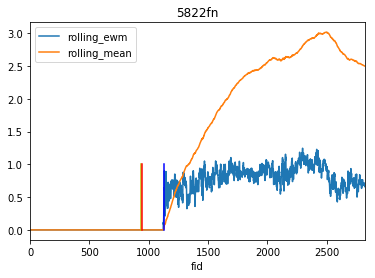

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

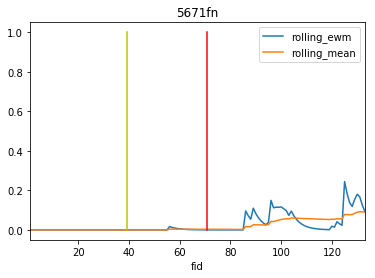

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

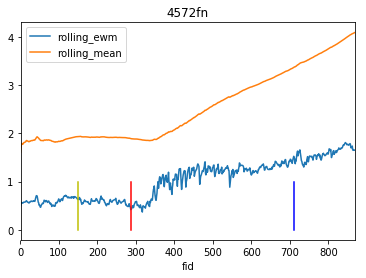

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

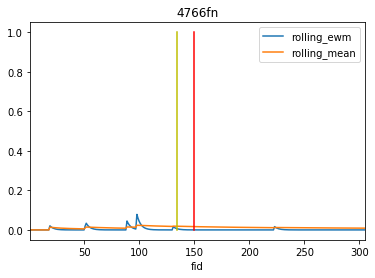

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

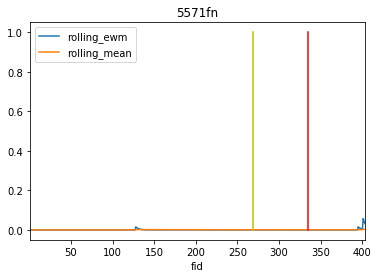

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

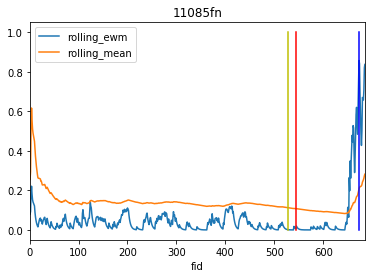

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

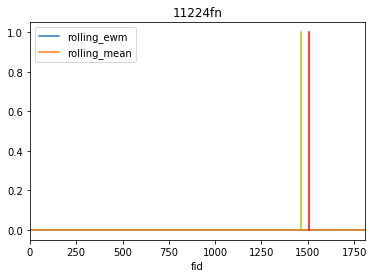

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

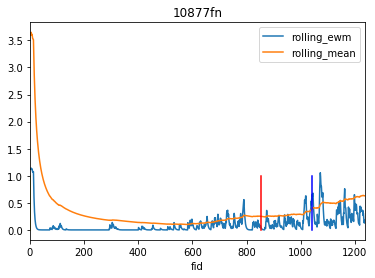

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

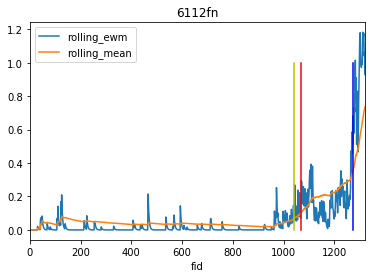

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

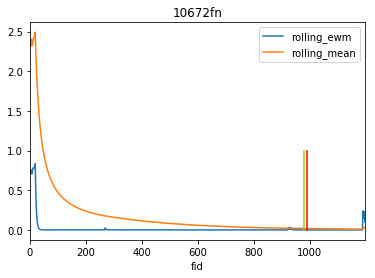

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

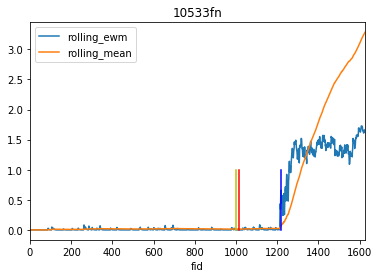

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

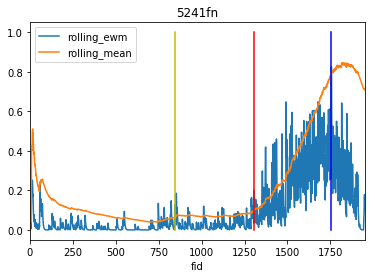

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

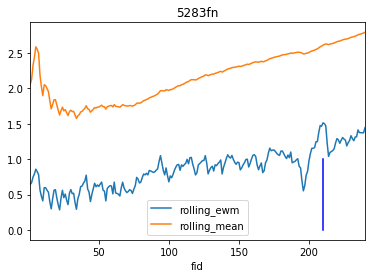

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

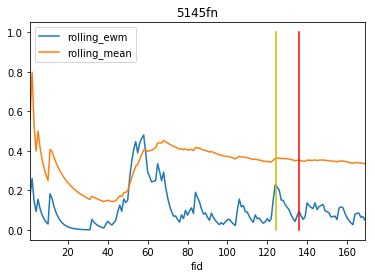

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

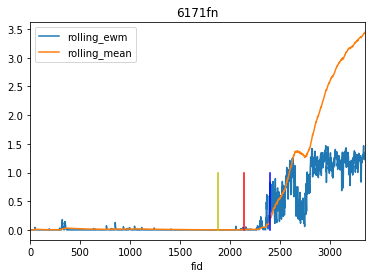

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

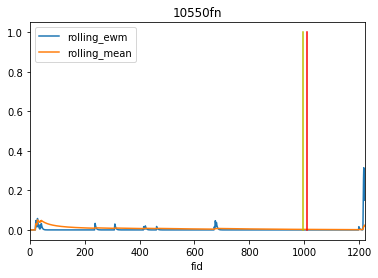

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

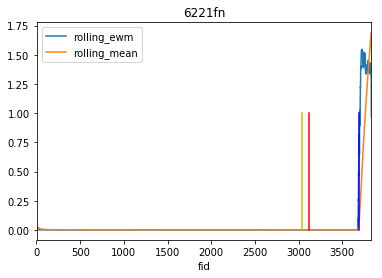

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

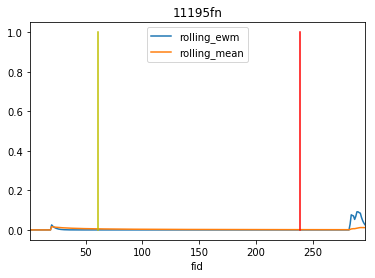

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

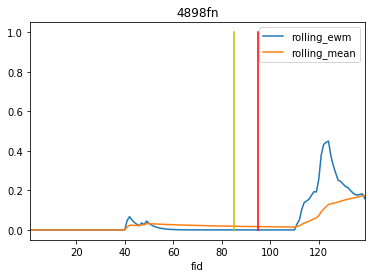

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

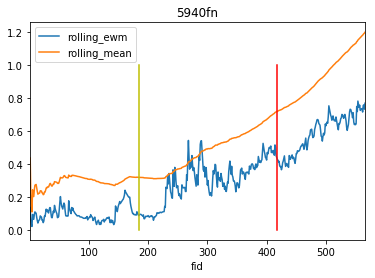

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

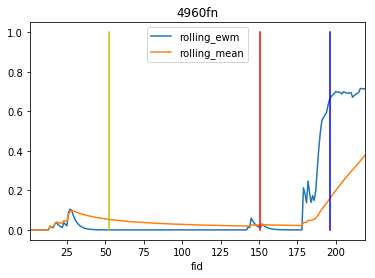

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

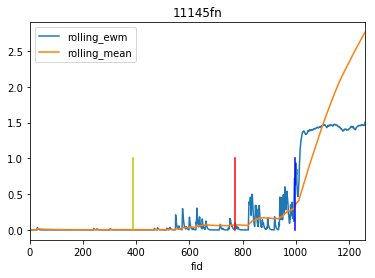

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

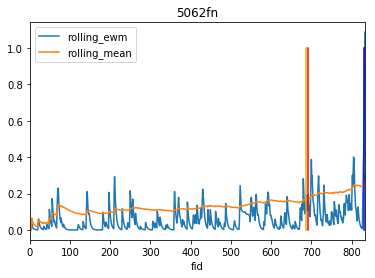

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

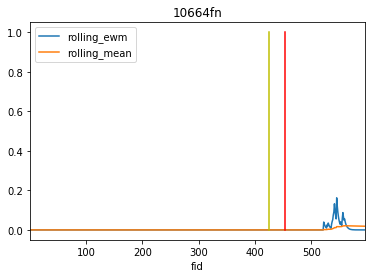

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

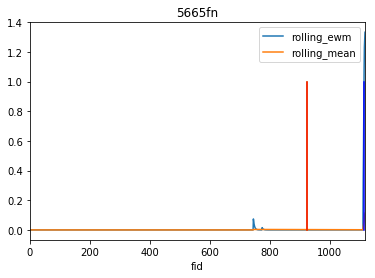

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

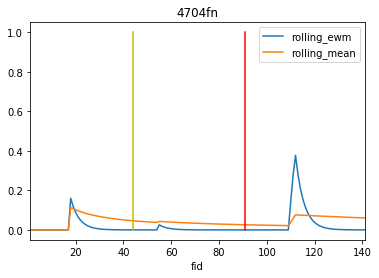

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

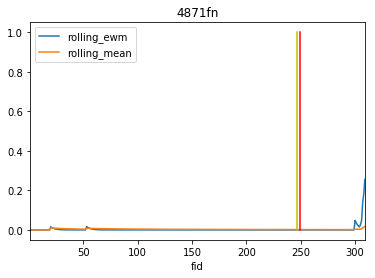

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

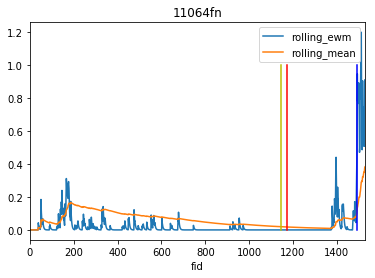

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

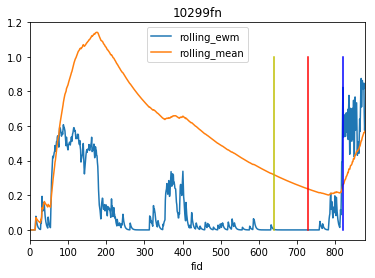

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

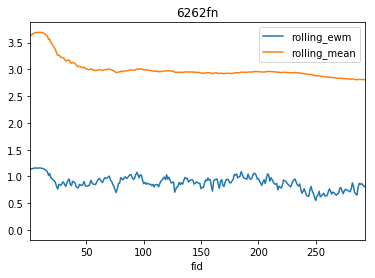

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

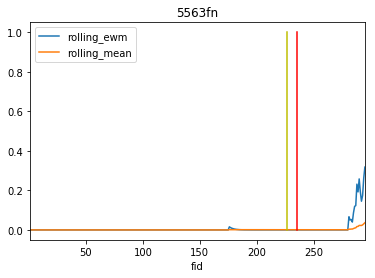

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

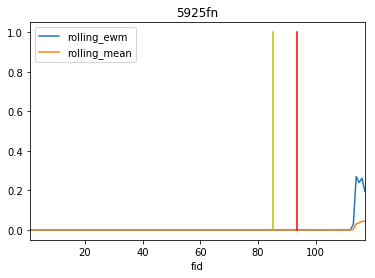

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

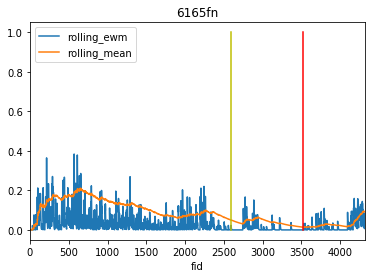

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

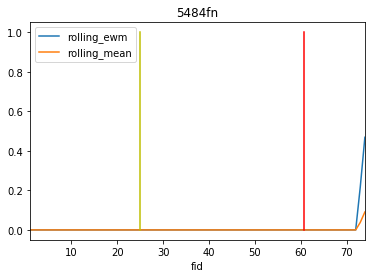

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

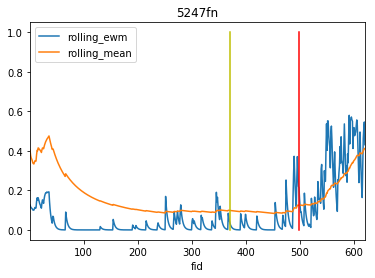

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

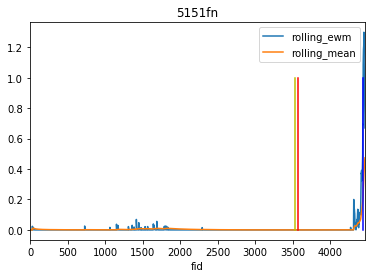

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

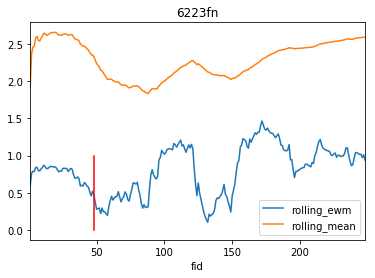

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

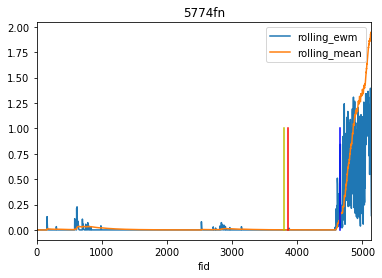

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

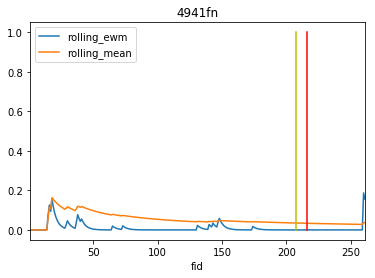

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

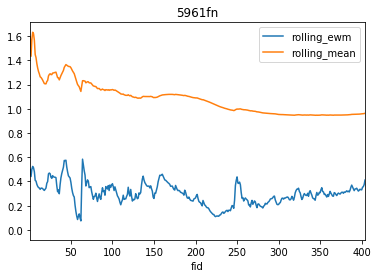

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

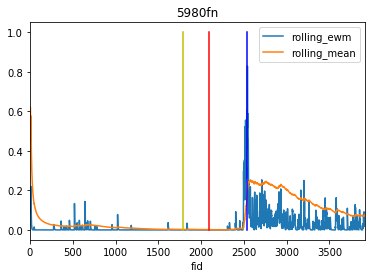

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

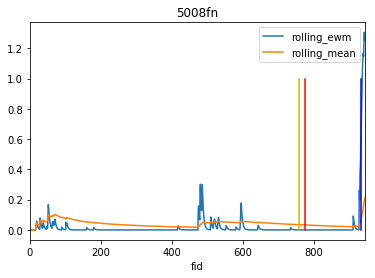

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

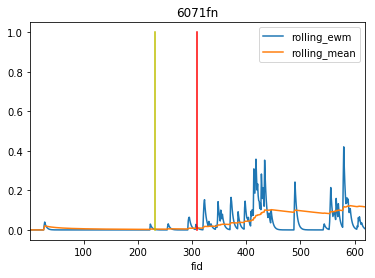

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

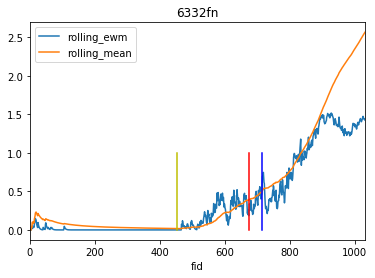

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

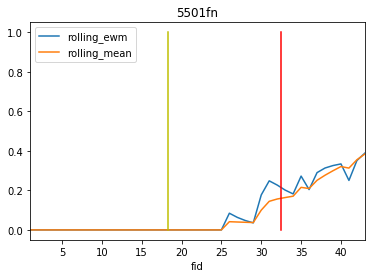

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

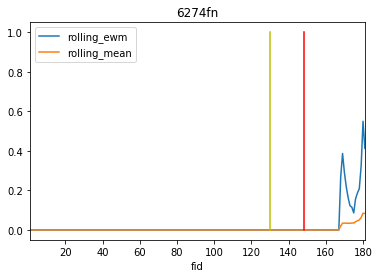

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

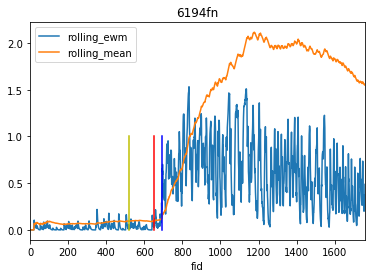

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

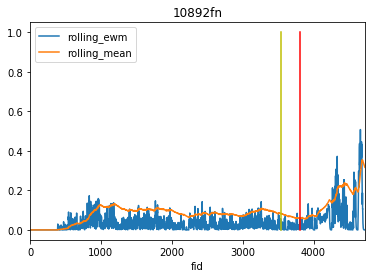

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

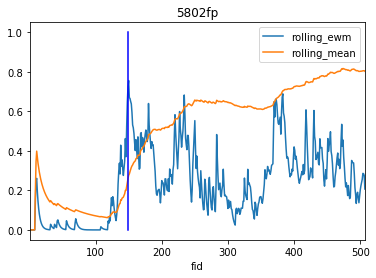

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

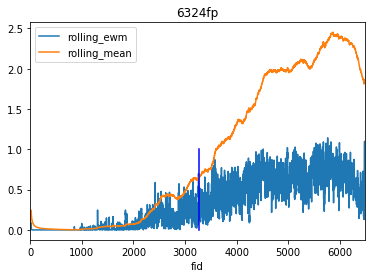

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

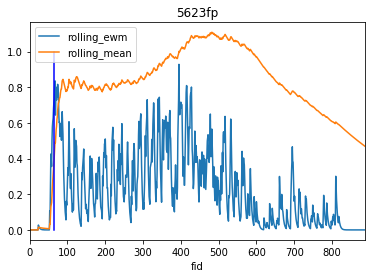

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

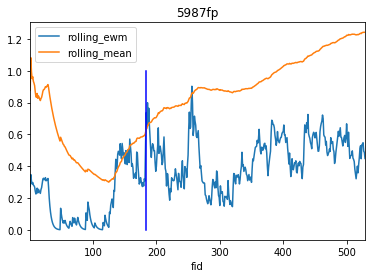

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

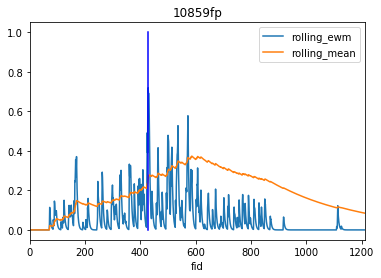

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

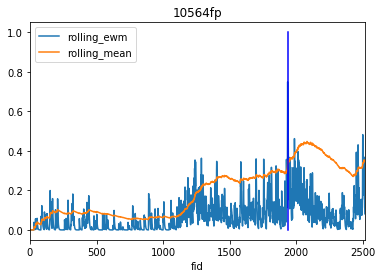

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

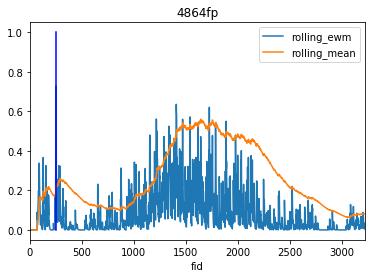

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

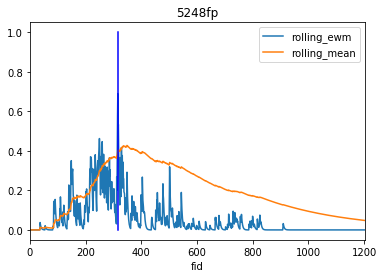

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

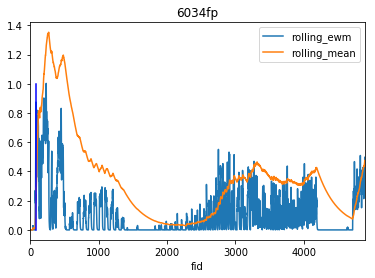

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

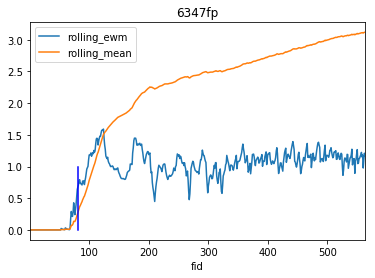

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

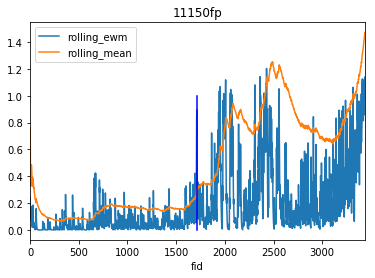

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

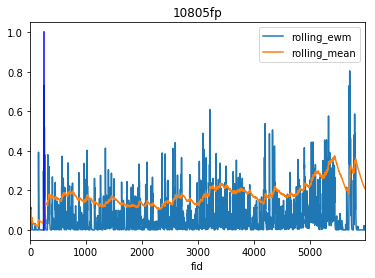

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

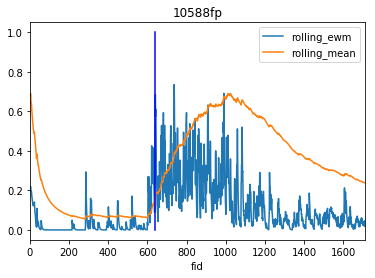

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

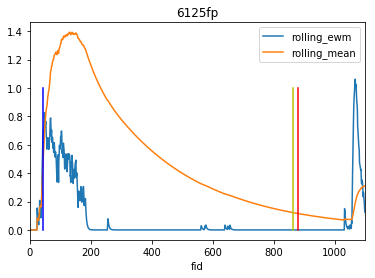

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

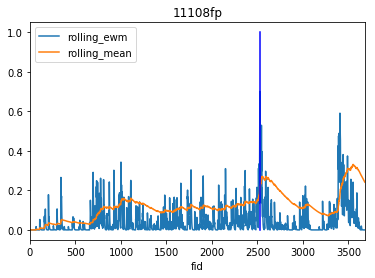

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

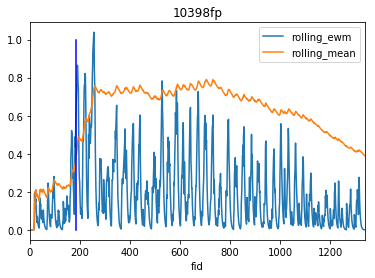

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

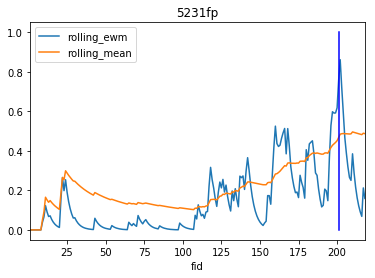

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

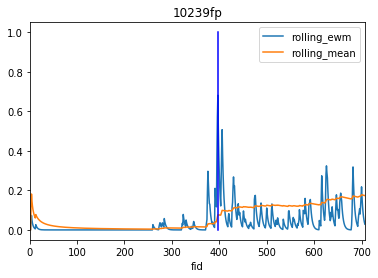

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

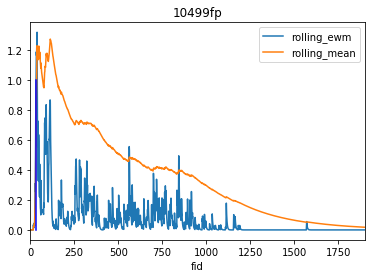

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

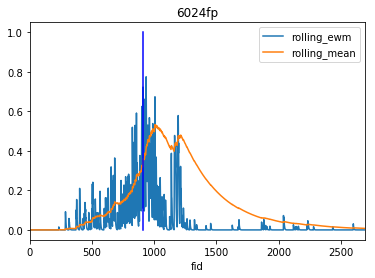

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

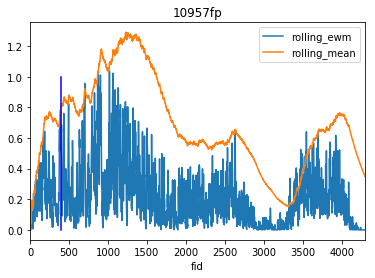

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

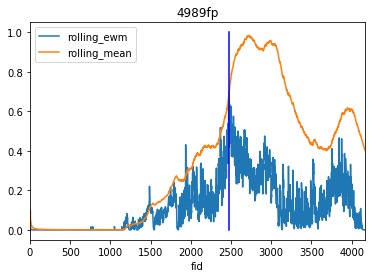

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

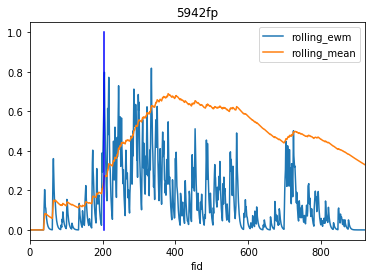

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

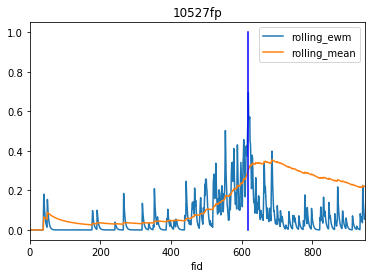

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

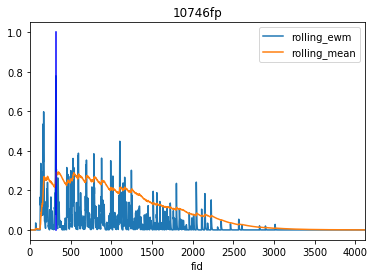

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

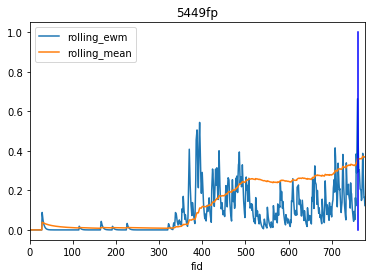

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

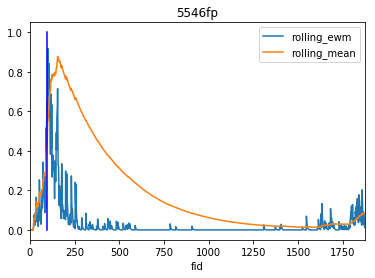

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

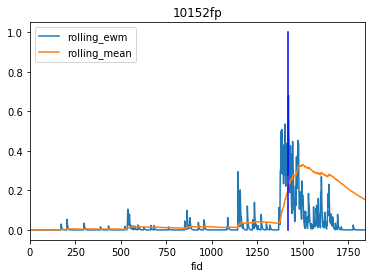

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

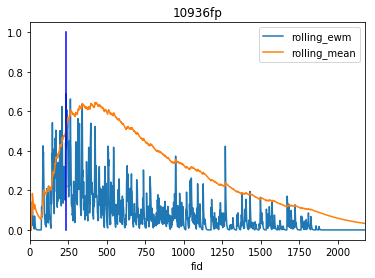

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

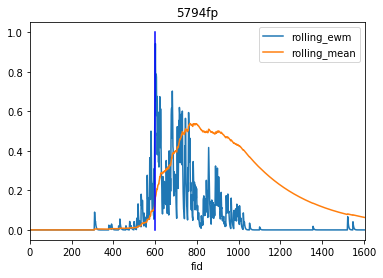

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

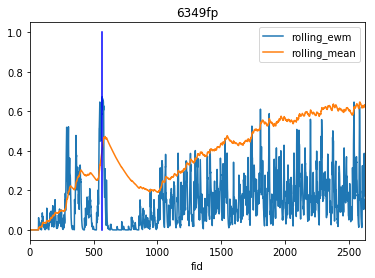

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

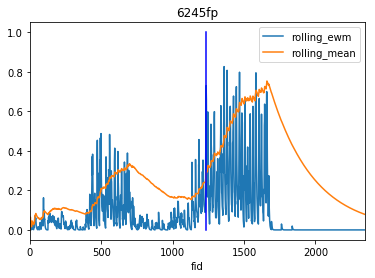

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

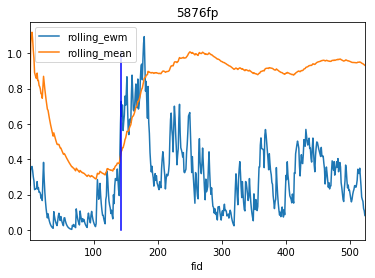

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

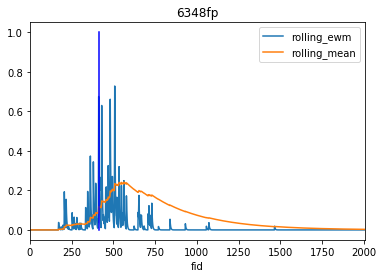

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

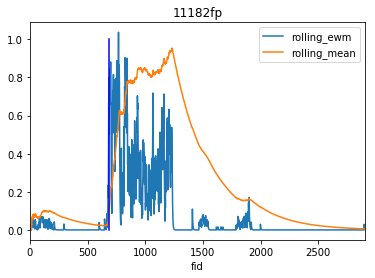

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

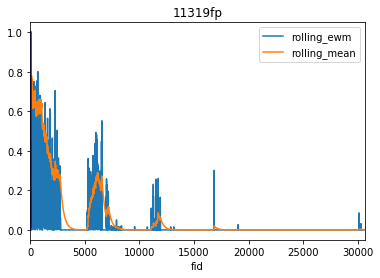

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

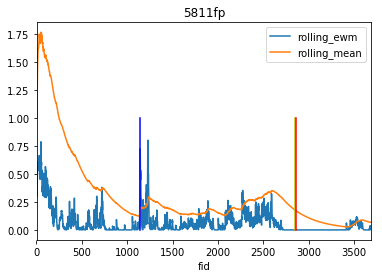

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

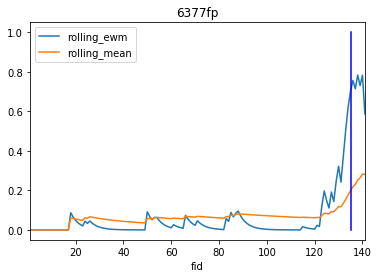

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

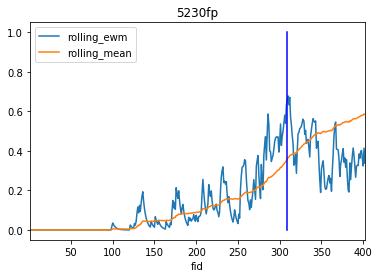

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

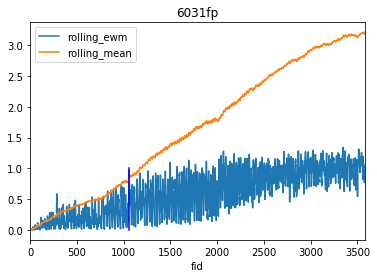

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

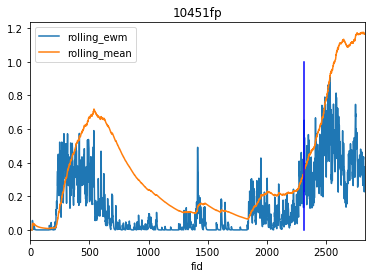

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

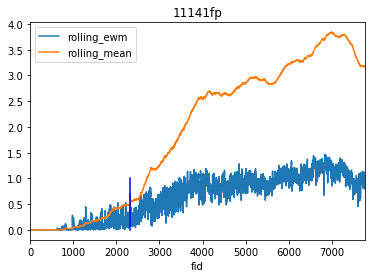

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

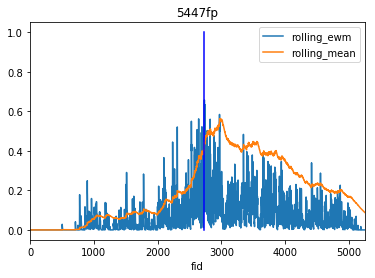

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

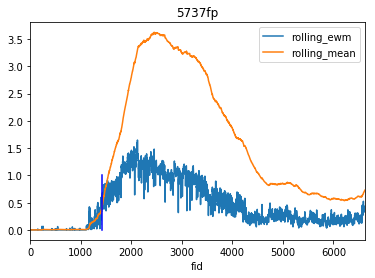

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

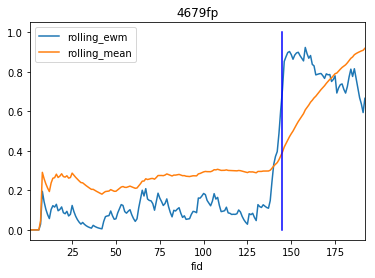

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

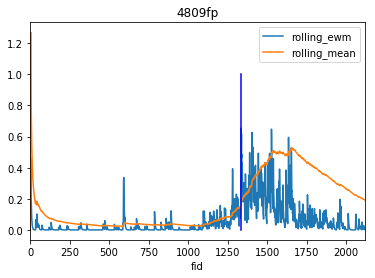

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

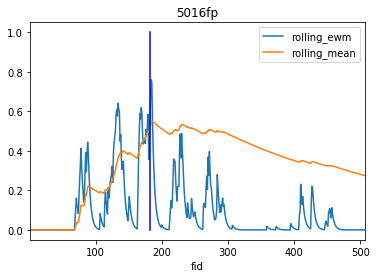

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

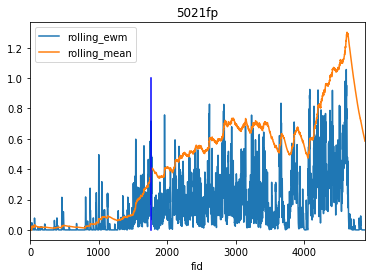

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

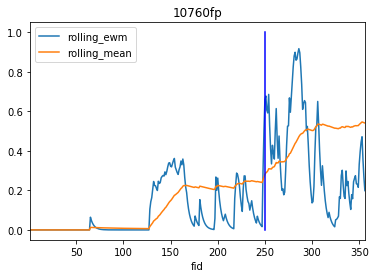

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

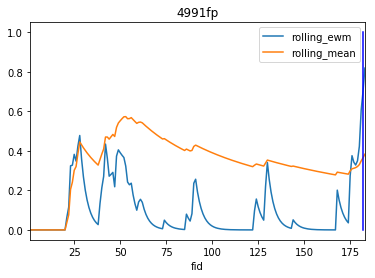

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

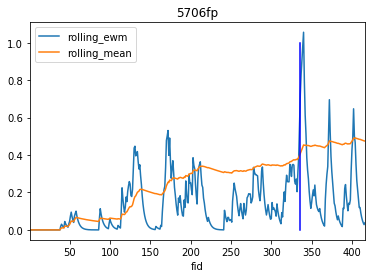

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

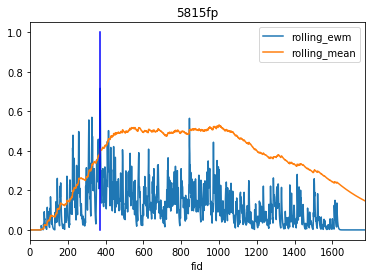

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

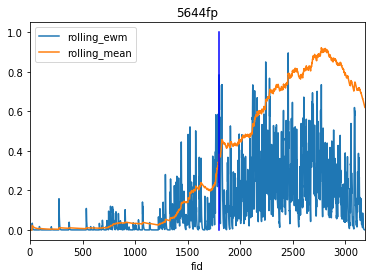

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

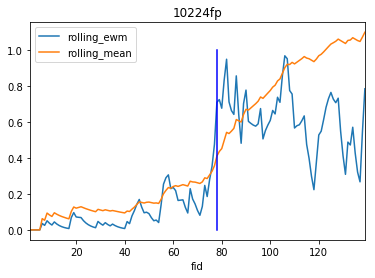

In [54]:
START1_RELAX = 2
START2_RELAX = 30

def eval_vids(vids_to_work_on, plot=False, **args):
    print(args)
    results = dict(p=[], fp=[], fn=[], tp=[], tn=[])
    for vid in vids_to_work_on:
        if plot:
            plt.figure()

        detected_failure_start = detect_failure_start(vid, plot=plot, **args)
#         detected_failure_start = detect_failure_start(vid, plot)
        if detected_failure_start == None:
            detected_failure_start = MAX_FRAME_NUM

        start1 = failure_starts.loc[int(vid)].start1
        start2 = failure_starts.loc[int(vid)].start2

        if (start1) < MAX_FRAME_NUM:
            results.get('p').append(vid)

        if detected_failure_start < start1 - START1_RELAX :
            result = 'fp'
        elif detected_failure_start > start2 + START2_RELAX:
            result = 'fn'
        elif detected_failure_start < MAX_FRAME_NUM:
            result = 'tp'
        else:
            result = 'tn'
        results.get(result).append(vid)

        if plot:
            if start1 < MAX_FRAME_NUM:
                plt.plot([start1, start1],[0,1], linestyle='-', color='y')
            if start2 < MAX_FRAME_NUM:
                plt.plot([start2, start2],[0,1], linestyle='-', color='r')
            if detected_failure_start < MAX_FRAME_NUM:
                plt.plot([detected_failure_start, detected_failure_start],[0,1], linestyle='-', color='b')
            plt.title(str(vid) + result)
    return results

# results = eval_vids(np.hstack((failed_videos.tail(30).index.values, succeeded_videos.tail(50).index.values)), False)
# results = eval_vids(np.hstack((failed_videos.head(20).index.values, succeeded_videos.head(50).index.values)))

# results = eval_vids(vids, thresh = 0.16, v_thresh = 0.72, min_ewm = 0.18, ewm_span = 9, rolling_win = 50, rolling_multiple = 5.43)
eval_vids(results['fn'], min_ewm=0.65, rolling_multiple=3.2, rolling_win=300.0, thresh=0.06, v_thresh=1.5, ewm_span=7.0, plot=True)
eval_vids(results['fp'], min_ewm=0.65, rolling_multiple=3.2, rolling_win=300.0, thresh=0.06, v_thresh=1.5, ewm_span=7.0, plot=True)
# eval_vids([5283,
#  6221,
#  10877,], True)


In [50]:
precision = len(results['tp'])/(len(results['fp'])+len(results['tp']))
recall = len(results['tp'])/(len(results['p']))
f1 = 2*(precision*recall)/(precision+recall)
f0_5 = (1+0.25)*(precision*recall)/(0.25*precision+recall)
print(f1, f0_5, precision, recall)
print(len(results['fp']), len(results['fn']))

0.2517482517482518 0.3237410071942446 0.4 0.1836734693877551
54 54


In [ ]:
bad_frames = []
good_frames = []
for vid in results['fp']:
    start = detect_failure_start(vid, False)
    df = load_detections(str(vid), thresh = 0.16, ewm_span = 9, rolling_win = 50, rolling_multiple = 5.43)
    bad_frames += [df.loc[start:]]
    good_frames += [df.loc[0:start]]
    
bad_df_fp = reduce(lambda x, y: pd.concat([x,y], ignore_index=True), bad_frames)
good_df_fp = reduce(lambda x, y: pd.concat([x,y], ignore_index=True), good_frames)

print(bad_df_fp.mean())
print(bad_df_fp.var())
print(good_df_fp.mean())
print(good_df_fp.var())


bad_frames = []
ok_frames = []
good_frames = []
ok_ratios = []
bad_ratios = []
for vid, video in failed_videos.iterrows():
    df = load_detections(str(vid), thresh = 0.16, ewm_span = 9, rolling_win = 50, rolling_multiple = 5.43)
    ok_frames += [df.loc[video.start1:video.start2]]
    bad_frames += [df.loc[video.start2:]]
    good_frames += [df.loc[0:video.start1]]
    ok_ratios += [good_frames[-1].p1.mean()/ok_frames[-1].p1.mean()]
    bad_ratios += [good_frames[-1].p1.mean()/bad_frames[-1].p1.mean()]
    
bad_df = reduce(lambda x, y: pd.concat([x,y], ignore_index=True), bad_frames)
ok_df = reduce(lambda x, y: pd.concat([x,y], ignore_index=True), ok_frames)
good_df = reduce(lambda x, y: pd.concat([x,y], ignore_index=True), good_frames)

succeeded_vids = [load_detections(str(i), thresh = 0.16, ewm_span = 9, rolling_win = 50, rolling_multiple = 5.43) for i in failure_starts[failure_starts.start1 >= MAX_FRAME_NUM].index]
succeeded_frames = reduce(lambda x, y: pd.concat([x,y], ignore_index=True), succeeded_vids)

print(bad_df.mean())
print(bad_df.var())
print(ok_df.mean())
print(ok_df.var())
print(good_df.mean())
print(good_df.var())
print(succeeded_frames.mean())
print(succeeded_frames.var())
print(len(bad_df))
print(len(good_df))
print(len(succeeded_frames))
good_df.accu_detection.hist(bins=50, alpha=0.5)
bad_df.accu_detection.hist(bins=50, alpha=0.5)


In [ ]:
import pickle
import time
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

def objective(x):
#     print(x)
    hyper_vids = np.hstack((failed_videos.sample(100).index.values, succeeded_videos.sample(100).index.values))
    eval_res = eval_vids(vids, plot=False, thresh = x['thresh'], v_thresh = x['v_thresh'], min_ewm = x['min_ewm'], ewm_span = x['ewm_span'], rolling_win = x['rolling_win'], rolling_multiple = x['rolling_multiple'])
    eval_res['precision'] = len(eval_res['tp'])/(len(eval_res['fp'])+len(eval_res['tp']))
    eval_res['recall'] = len(eval_res['tp'])/(len(eval_res['p']))
    eval_res['f1'] = 2*(eval_res['precision']*eval_res['recall'])/(eval_res['precision']+eval_res['recall'])
    eval_res['f0.5'] = (1+0.25)*(eval_res['precision']*eval_res['recall'])/(0.25*eval_res['precision']+eval_res['recall'])
    loss = 1 - eval_res['f1']
    print(loss)
    return {
        'loss': loss,
        'status': STATUS_OK,
        # -- store other results like this
        'eval_time': time.time(),
        'results': results,
        }

trials = Trials()

space = {
    'thresh': hp.quniform('thresh', 0.05, 0.3, 0.02),
    'v_thresh': hp.quniform('v_thresh', 1.5, 3, 0.1),
    'min_ewm': hp.quniform('min_ewm', 0.3, 0.7, 0.05),
    'ewm_span': hp.quniform('ewm_span', 2, 30, 1),
    'rolling_win': hp.quniform('rolling_win', 150, 300, 10),
    'rolling_multiple': hp.quniform('rolling_multiple', 3, 4, 0.1)
}
best = fmin(objective,
    space=space,
    algo=tpe.suggest,
    max_evals=2000,
    trials=trials)


{'min_ewm': 0.30000000000000004, 'rolling_multiple': 3.7, 'rolling_win': 230.0, 'thresh': 0.08, 'v_thresh': 2.7, 'ewm_span': 24.0}
0.8628158844765343
{'min_ewm': 0.45, 'rolling_multiple': 3.2, 'rolling_win': 190.0, 'thresh': 0.1, 'v_thresh': 2.0, 'ewm_span': 4.0}
0.768762677484787
{'min_ewm': 0.45, 'rolling_multiple': 3.4000000000000004, 'rolling_win': 290.0, 'thresh': 0.12, 'v_thresh': 1.9000000000000001, 'ewm_span': 17.0}
0.8195488721804511
{'min_ewm': 0.65, 'rolling_multiple': 3.1, 'rolling_win': 190.0, 'thresh': 0.14, 'v_thresh': 2.4000000000000004, 'ewm_span': 22.0}
0.943127962085308
{'min_ewm': 0.55, 'rolling_multiple': 3.5, 'rolling_win': 250.0, 'thresh': 0.26, 'v_thresh': 2.3000000000000003, 'ewm_span': 28.0}
0.9523809523809523
{'min_ewm': 0.55, 'rolling_multiple': 3.5, 'rolling_win': 250.0, 'thresh': 0.22, 'v_thresh': 2.2, 'ewm_span': 2.0}
0.7510729613733905
{'min_ewm': 0.35000000000000003, 'rolling_multiple': 4.0, 'rolling_win': 260.0, 'thresh': 0.08, 'v_thresh': 2.4000000000

Text(0, 0.5, '$val$')

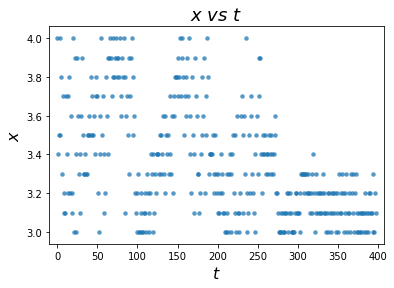

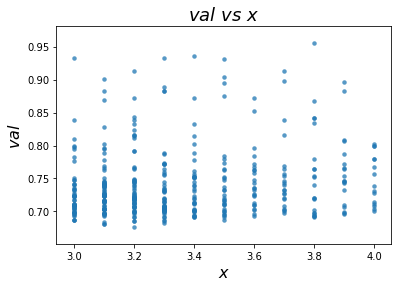

In [47]:
f, ax = plt.subplots(1)
xs = [t['tid'] for t in trials.trials[:-1]]
ys = [t['misc']['vals']['rolling_multiple'] for t in trials.trials[:-1]]
ax.set_xlim(xs[0]-10, xs[-1]+10)
ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75)
ax.set_title('$x$ $vs$ $t$ ', fontsize=18)
ax.set_xlabel('$t$', fontsize=16)
ax.set_ylabel('$x$', fontsize=16)

f, ax = plt.subplots(1)
xs = [t['misc']['vals']['rolling_multiple'] for t in trials.trials[:-1]]
ys = [t['result']['loss'] for t in trials.trials[:-1]]
ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75)
ax.set_title('$val$ $vs$ $x$ ', fontsize=18)
ax.set_xlabel('$x$', fontsize=16)
ax.set_ylabel('$val$', fontsize=16)

In [48]:
tdf = pd.DataFrame([{**t['misc']['vals'], **dict(loss=[t['result']['loss']])} for t in trials.trials[:-1]])
tdf = tdf.applymap(lambda x: x[0])
tdf[tdf.loss < 63 ].corr()
# tdf.corr()
# rolling_multiple = 3-4
# rolling_win > 150
# min_ewm > 0.3
# ewm_span 12 - 20
# v_thresh > 1.5
# thresh 0.05 - 0.3
tdf.sort_values(by=['loss']).head(50)

,ewm_span,loss,min_ewm,rolling_multiple,rolling_win,thresh,v_thresh
273,7.0,0.676259,0.65,3.2,300.0,0.06,1.5
207,8.0,0.681034,0.60,3.1,290.0,0.08,2.0
323,8.0,0.681034,0.60,3.1,300.0,0.08,1.7
304,6.0,0.681953,0.55,3.3,270.0,0.20,1.7
373,8.0,0.683642,0.50,3.1,180.0,0.20,1.6
333,7.0,0.685185,0.65,3.2,210.0,0.06,2.0
339,7.0,0.685185,0.65,3.2,200.0,0.06,2.1
198,7.0,0.685430,0.60,3.3,280.0,0.10,2.8
222,5.0,0.687500,0.60,3.5,260.0,0.22,1.6
276,10.0,0.687500,0.60,3.0,290.0,0.08,1.5


In [187]:
# Hyperparameter grid search

thresh_arr = np.linspace(0.05, 0.3, 3)
v_thresh_arr = np.linspace(1.5, 3, 2)
min_ewm_arr = np.linspace(0.3, 0.7, 3)
ewm_span_arr = np.linspace(2, 30, 3)
rolling_win_arr = np.linspace(150, 300, 5)
rolling_multiple_arr = np.linspace(3, 4, 2)

loss_arr = []
for r in np.array(np.meshgrid(thresh_arr, v_thresh_arr, min_ewm_arr, ewm_span_arr, rolling_win_arr, rolling_multiple_arr)).T.reshape(-1,6):
    loss_arr += [objective(dict(thresh=r[0], v_thresh=r[1], min_ewm=r[2], ewm_span=r[3], rolling_win=r[4], rolling_multiple=r[5]))]


{'v_thresh': 1.5, 'min_ewm': 0.3, 'rolling_win': 150.0, 'ewm_span': 2.0, 'rolling_multiple': 3.0, 'thresh': 0.05}
674
{'v_thresh': 3.0, 'min_ewm': 0.3, 'rolling_win': 150.0, 'ewm_span': 2.0, 'rolling_multiple': 3.0, 'thresh': 0.05}
674
{'v_thresh': 1.5, 'min_ewm': 0.3, 'rolling_win': 150.0, 'ewm_span': 2.0, 'rolling_multiple': 3.0, 'thresh': 0.175}
547
{'v_thresh': 3.0, 'min_ewm': 0.3, 'rolling_win': 150.0, 'ewm_span': 2.0, 'rolling_multiple': 3.0, 'thresh': 0.175}
547
{'v_thresh': 1.5, 'min_ewm': 0.3, 'rolling_win': 150.0, 'ewm_span': 2.0, 'rolling_multiple': 3.0, 'thresh': 0.3}
470
{'v_thresh': 3.0, 'min_ewm': 0.3, 'rolling_win': 150.0, 'ewm_span': 2.0, 'rolling_multiple': 3.0, 'thresh': 0.3}
470
{'v_thresh': 1.5, 'min_ewm': 0.5, 'rolling_win': 150.0, 'ewm_span': 2.0, 'rolling_multiple': 3.0, 'thresh': 0.05}
367
{'v_thresh': 3.0, 'min_ewm': 0.5, 'rolling_win': 150.0, 'ewm_span': 2.0, 'rolling_multiple': 3.0, 'thresh': 0.05}
367
{'v_thresh': 1.5, 'min_ewm': 0.5, 'rolling_win': 150.0, 

KeyboardInterrupt: 